In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations

In [3]:
import sys
sys.path.append('..')

from util.participant_stream import ParticipantStream

In [4]:
# restrict rng for reproducibility
rng = np.random.default_rng(3098)

# Theoretical KDE
Consider the problem of uniformly sampling all possible age pairs:  
- assume that a pair is of the form (younger_age, older_age)
- range of possible ages are 19 - 80

In [5]:
def continuous_uniform_range_pair(lower_bound, upper_bound, num_samples):
    samples = rng.uniform(lower_bound, upper_bound, (2, num_samples))
    for i in range(num_samples):
        while samples[0,i] == samples[1,i]:
            samples[0,i] = rng.uniform(lower_bound, upper_bound)
            samples[1,i] = rng.uniform(lower_bound, upper_bound)
        if samples[0,i] > samples[1, i]:
            samples[0,i], samples[1,i] = samples[1,i], samples[0,i]
    return samples

In [6]:
theory_num_samples = 50000
theory_samples = continuous_uniform_range_pair(19, 80, theory_num_samples)

In [7]:
# visualize distribution of theoretical surface
bins = 60
t_hist, t_younger_edges, t_older_edges = np.histogram2d(theory_samples[0], theory_samples[1], bins=bins, range=[[19,80],[19,80]], density=True)

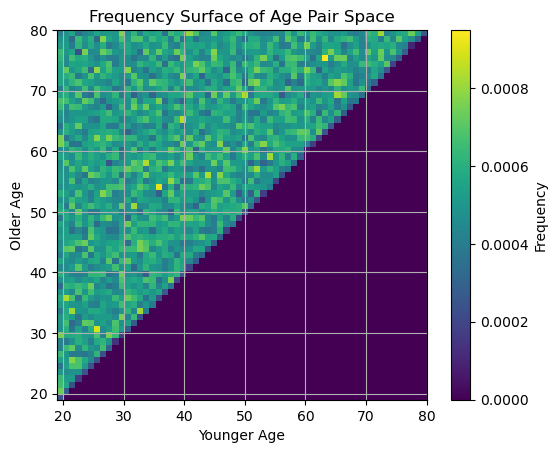

In [8]:
plt.imshow(t_hist.T, origin='lower', extent=[19, 80, 19, 80])
plt.colorbar(label='Frequency')
plt.title('Frequency Surface of Age Pair Space')
plt.xlabel('Younger Age')
plt.ylabel('Older Age')
plt.grid(True)
plt.show()

In [9]:
# define function for sampling from theoretical pdf
def generate_hist2d_pdf(hist, x_edges, y_edges):
    def sample_pdf(x, y):
        x_bin = np.argmax(np.where((np.expand_dims(x_edges, axis=1) < x).transpose(), x_edges, 0), axis=1)
        y_bin = np.argmax(np.where((np.expand_dims(y_edges, axis=1) < y).transpose(), y_edges, 0), axis=1)
        return hist[x_bin, y_bin]
    return sample_pdf
age_pdf = generate_hist2d_pdf(t_hist, t_younger_edges, t_older_edges)

# Algo 1: Greedy by All Pairs
1. Construct KDE over space of all possible pairs
2. Evaluate KDE on all possible pairs
3. Greedily select in order of lowest probability sample

## Simulation Setup

In [10]:
stream = ParticipantStream(rng=rng)

In [11]:
def generate_batch(n):
    return stream.generate_participants(n)

In [12]:
# list of datapoints across all batches
datapoints = None
data_kde = None
batches = 0
scores = {"linear": [], "squared": []}

In [13]:
def add_batch(samples: np.ndarray):
    # assuming samples come in the form of [[p1, p2], [p1, p2], ...]
    global datapoints, data_kde, batches
    if datapoints is not None:
        datapoints = np.hstack([datapoints, samples.transpose()])
    else:
        datapoints = np.copy(samples.transpose())
    data_kde = stats.gaussian_kde(datapoints)
    batches += 1

In [14]:
def global_pdf(samples: np.ndarray):
    global datapoints, data_kde
    if datapoints is not None:
        return data_kde(samples)
    return np.zeros(samples.shape[1])

## Batch 1 Process

In [15]:
pool = generate_batch(100)

In [16]:
# extract age feature from participant metadata
ages = np.fromiter((p['age'] for p in pool), dtype=int)

In [17]:
# sample possible pairs to build kde
sampled_pairs = rng.choice(ages, (2, 10000))
sample_pdf = stats.gaussian_kde(sampled_pairs)
sampled_pairs

array([[45, 53, 50, ..., 39, 53, 65],
       [28, 56, 50, ..., 52, 23, 21]])

In [18]:
# get all possible pairings given pool
all_pairs = combinations(ages, 2)
all_pairs = np.array(list(all_pairs))
all_pairs

array([[31, 40],
       [31, 41],
       [31, 40],
       ...,
       [37, 75],
       [37, 53],
       [75, 53]])

In [19]:
# compute probability of the pairings occuring, adjusted by what's already in batch
all_pairs_prob = sample_pdf(all_pairs.transpose()) + global_pdf(all_pairs.transpose())
all_pairs_prob

array([3.94354838e-04, 3.94273660e-04, 3.94354838e-04, ...,
       9.89378688e-05, 5.16307959e-04, 1.59275785e-04])

In [20]:
# sort all pairs from lowest probability to highest probability
best_pairs = np.take(all_pairs, np.argsort(all_pairs_prob), axis=0)
best_pairs

array([[64, 75],
       [64, 75],
       [62, 75],
       ...,
       [50, 51],
       [50, 51],
       [50, 51]])

In [21]:
# Greedily pick pairs to sample
age_map = {}
for p in pool:
    if p['age'] not in age_map:
        age_map[p['age']] = [p]
    else:
        age_map[p['age']].append(p)
grouping = []
age_grouping = []
for pair in all_pairs:
    p1 = int(pair[0])
    p2 = int(pair[1])
    if p1 > p2:
        p1, p2 = p2, p1
    if p1 not in age_map or p2 not in age_map:
        continue
    if p1 == p2 and len(age_map[p1]) < 2:
        continue
    grouping.append((age_map[p1].pop(), age_map[p2].pop()))
    age_grouping.append([p1, p2])
    if len(age_map[p1]) == 0:
        del age_map[p1]
    if p2 != p1 and len(age_map[p2]) == 0:
        del age_map[p2]
    if not age_map:
        break
grouping

[({'party': 'Republican',
   'age': 31,
   'gender': 'M',
   'arrival_time': 18,
   'departure_time': 55},
  {'party': 'Republican',
   'age': 40,
   'gender': 'F',
   'arrival_time': 10,
   'departure_time': 17}),
 ({'party': 'Democrat',
   'age': 31,
   'gender': 'F',
   'arrival_time': 14,
   'departure_time': 24},
  {'party': 'Independent',
   'age': 41,
   'gender': 'M',
   'arrival_time': 20,
   'departure_time': 159}),
 ({'party': 'Independent',
   'age': 31,
   'gender': 'F',
   'arrival_time': 9,
   'departure_time': 49},
  {'party': 'Republican',
   'age': 40,
   'gender': 'M',
   'arrival_time': 3,
   'departure_time': 37}),
 ({'party': 'Democrat',
   'age': 30,
   'gender': 'F',
   'arrival_time': 4,
   'departure_time': 40},
  {'party': 'Democrat',
   'age': 31,
   'gender': 'F',
   'arrival_time': 2,
   'departure_time': 7}),
 ({'party': 'Democrat',
   'age': 40,
   'gender': 'F',
   'arrival_time': 2,
   'departure_time': 12},
  {'party': 'Republican',
   'age': 41,
   '

In [22]:
len(grouping)

50

In [23]:
# update sampled dataset
add_batch(np.array(age_grouping))

## Evaluate Batch 1

In [24]:
# sample every bin of kde
x_coords, y_coords = np.mgrid[19:80, 19:80]
pos = np.vstack([x_coords.ravel(), y_coords.ravel()])
z = np.reshape(data_kde(pos).T, x_coords.shape)

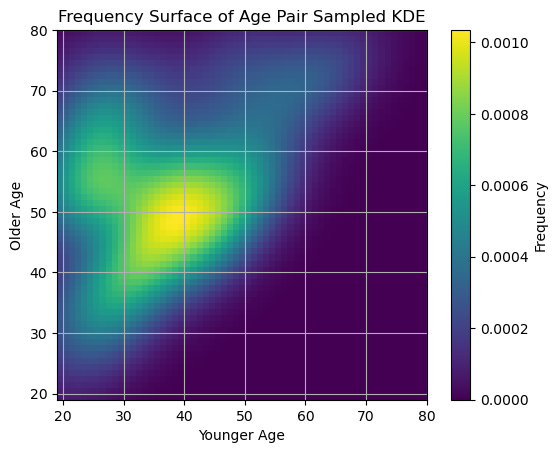

In [25]:
# plot kde
plt.imshow(z.T, origin='lower', extent=[19, 80, 19, 80])
plt.colorbar(label='Frequency')
plt.title('Frequency Surface of Age Pair Sampled KDE')
plt.xlabel('Younger Age')
plt.ylabel('Older Age')
plt.grid(True)
plt.show()

In [26]:
# compute difference between theoretical and dataset at every bin
dif = np.reshape((age_pdf(pos[0], pos[1]) - data_kde(pos)).T, x_coords.shape)

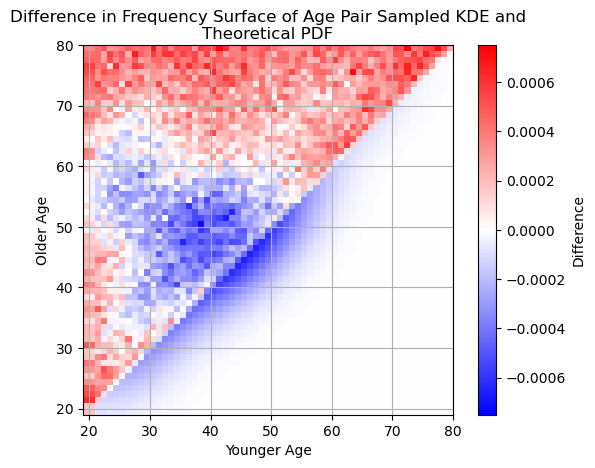

In [27]:
# plot difference
cmap_max = np.max(np.abs(dif))
plt.imshow(dif.T, origin='lower', extent=[19, 80, 19, 80], cmap="bwr", vmin=-cmap_max, vmax=cmap_max)
plt.colorbar(label='Difference')
plt.title('Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
plt.xlabel('Younger Age')
plt.ylabel('Older Age')
plt.grid(True)
plt.show()

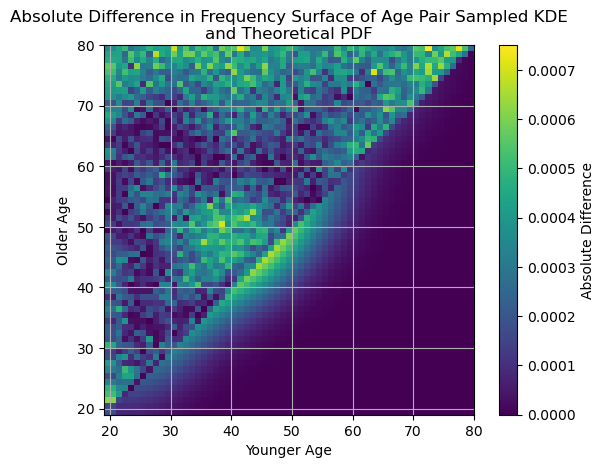

In [28]:
# plot abs difference
plt.imshow(np.abs(dif).T, origin='lower', extent=[19, 80, 19, 80])
plt.colorbar(label='Absolute Difference')
plt.title('Absolute Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF' , wrap=True)
plt.xlabel('Younger Age')
plt.ylabel('Older Age')
plt.grid(True)
plt.show()

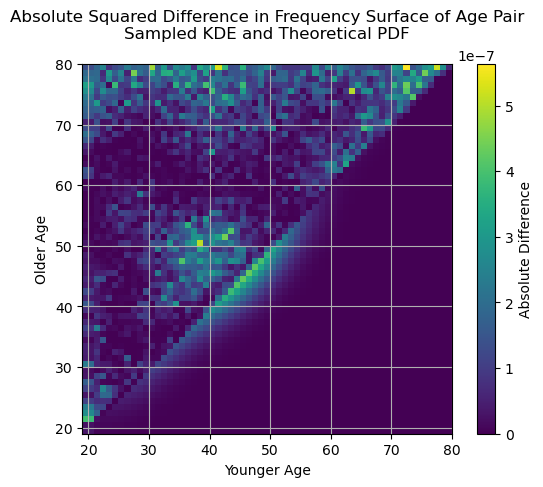

In [29]:
# plot squared difference
plt.imshow(np.abs(dif ** 2).T, origin='lower', extent=[19, 80, 19, 80])
plt.colorbar(label='Absolute Difference')
plt.title('Absolute Squared Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', pad=20, wrap=True)
plt.xlabel('Younger Age')
plt.ylabel('Older Age')
plt.grid(True)
plt.show()

In [30]:
# linear score
np.sum(np.triu(np.abs(dif)))

0.4694495373606337

In [31]:
# square score
np.sum(np.triu(np.abs(dif ** 2)))

0.00016137186073681472

# Batch 2 - N

In [32]:
def run_batch():
    pool = generate_batch(100)
    # extract age feature from participant metadata
    ages = np.fromiter((p['age'] for p in pool), dtype=int)
    # sample possible pairs to build kde
    sampled_pairs = rng.choice(ages, (2, 10000))
    sample_pdf = stats.gaussian_kde(sampled_pairs)
    # get all possible pairings given pool
    all_pairs = np.array(list(combinations(ages, 2)))
    # compute probability of the pairings occuring, adjusted by what's already in batch
    all_pairs_prob = sample_pdf(all_pairs.transpose()) + global_pdf(all_pairs.transpose())
    # sort all pairs from lowest probability to highest probability
    best_pairs = np.take(all_pairs, np.argsort(all_pairs_prob), axis=0)
    # Greedily pick pairs to sample
    age_map = {}
    for p in pool:
        if p['age'] not in age_map:
            age_map[p['age']] = [p]
        else:
            age_map[p['age']].append(p)
    grouping = []
    age_grouping = []
    for pair in all_pairs:
        p1 = int(pair[0])
        p2 = int(pair[1])
        if p1 > p2:
            p1, p2 = p2, p1
        if p1 not in age_map or p2 not in age_map:
            continue
        if p1 == p2 and len(age_map[p1]) < 2:
            continue
        grouping.append((age_map[p1].pop(), age_map[p2].pop()))
        age_grouping.append([p1, p2])
        if len(age_map[p1]) == 0:
            del age_map[p1]
        if p2 != p1 and len(age_map[p2]) == 0:
            del age_map[p2]
        if not age_map:
            break
    # update sampled dataset
    add_batch(np.array(age_grouping))

In [33]:
def evaluate_dataset(plot=False):
    x_coords, y_coords = np.mgrid[19:80, 19:80]
    pos = np.vstack([x_coords.ravel(), y_coords.ravel()])
    
    z = np.reshape(data_kde(pos).T, x_coords.shape)
    dif = np.reshape((age_pdf(pos[0], pos[1]) - data_kde(pos)).T, x_coords.shape)
    
    if plot:
        fig, axes = plt.subplots(4, 1, figsize=(6, 20))

        a0 = axes[0].imshow(z.T, origin='lower', extent=[19, 80, 19, 80])
        fig.colorbar(a0, ax=axes[0], label='Frequency')
        axes[0].set_title('Frequency Surface of Age Pair Sampled KDE')
        axes[0].set_xlabel('Younger Age')
        axes[0].set_ylabel('Older Age')
        axes[0].grid(True)
        
        cmap_max = np.max(np.abs(dif))
        a1 = axes[1].imshow(dif.T, origin='lower', extent=[19, 80, 19, 80], cmap="bwr", vmin=-cmap_max, vmax=cmap_max)
        fig.colorbar(a1, ax=axes[1], label='Difference')
        axes[1].set_title('Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
        axes[1].set_xlabel('Younger Age')
        axes[1].set_ylabel('Older Age')
        axes[1].grid(True)

        a2 = axes[2].imshow(np.abs(dif).T, origin='lower', extent=[19, 80, 19, 80])
        fig.colorbar(a2, ax=axes[2], label='Absolute Difference')
        axes[2].set_title('Absolute Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
        axes[2].set_xlabel('Younger Age')
        axes[2].set_ylabel('Older Age')
        axes[2].grid(True)

        a3 = axes[3].imshow(np.abs(dif ** 2).T, origin='lower', extent=[19, 80, 19, 80])
        fig.colorbar(a3, ax=axes[3], label='Absolute Squared Difference')
        axes[3].set_title('Absolute Squared Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', pad=20, wrap=True)
        axes[3].set_xlabel('Younger Age')
        axes[3].set_ylabel('Older Age')
        axes[3].grid(True)   

        fig.tight_layout()

    return {"linear": np.sum(np.triu(np.abs(dif))), "squared": np.sum(np.triu(np.abs(dif ** 2)))}

{'linear': [0.4694495373606337], 'squared': [0.00016137186073681472]}

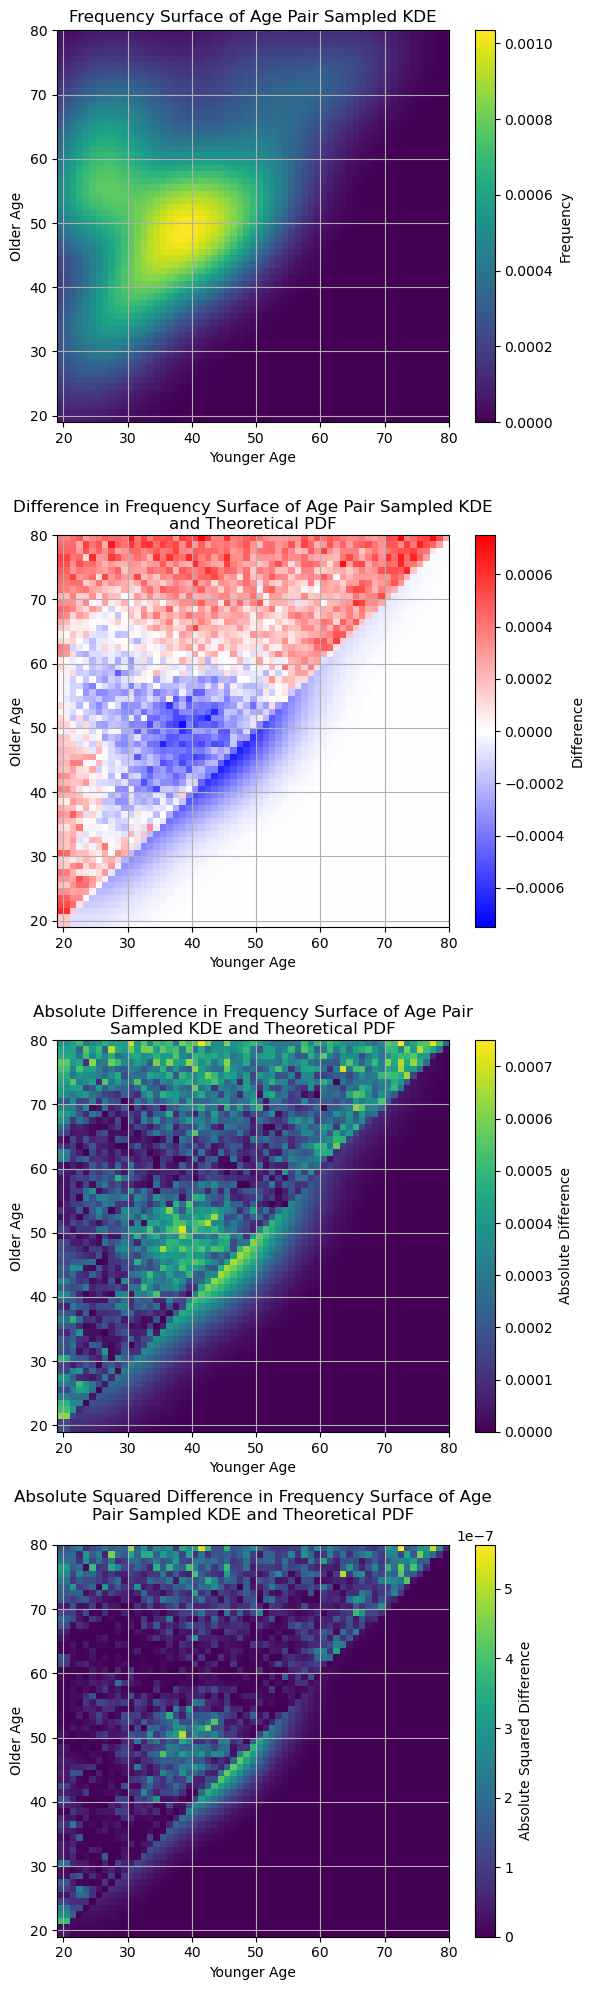

In [34]:
res = evaluate_dataset(plot=True)
scores["linear"].append(res['linear'])
scores["squared"].append(res['squared'])
scores

{'linear': [0.4694495373606337, 0.5293676086209943],
 'squared': [0.00016137186073681472, 0.00020211055104678215]}

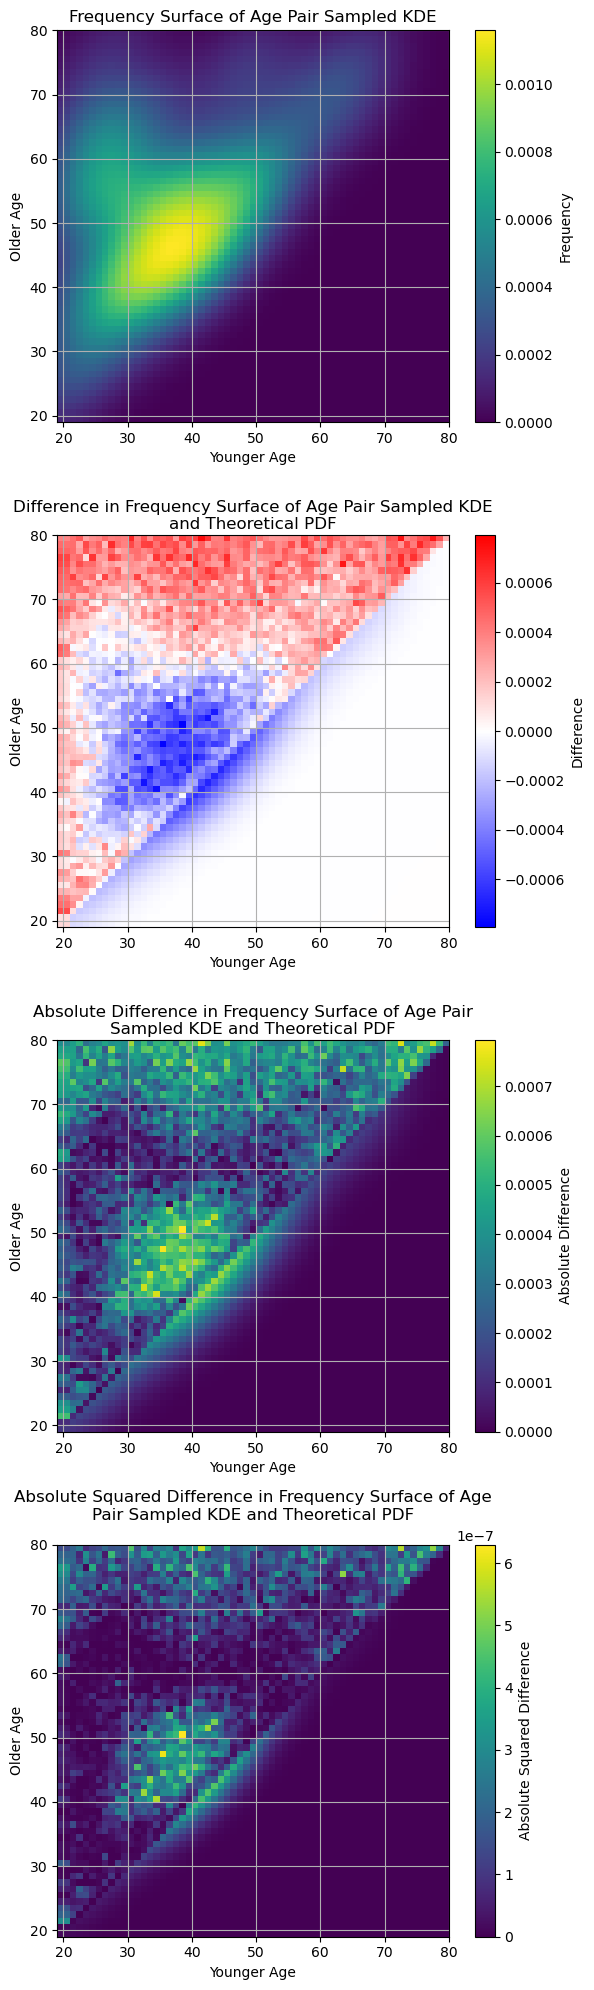

In [35]:
# BATCH 2
run_batch()
res = evaluate_dataset(plot=True)
scores["linear"].append(res['linear'])
scores["squared"].append(res['squared'])
scores

{'linear': [0.4694495373606337,
  0.5293676086209943,
  0.49176975915097576,
  0.506788020529894,
  0.5174035156943098,
  0.542822911354655,
  0.549176364493419,
  0.5545605125021555,
  0.5466669450666857,
  0.5492383673869521],
 'squared': [0.00016137186073681472,
  0.00020211055104678215,
  0.00017815649821371026,
  0.0001936535856895956,
  0.00019809628135801537,
  0.0002209962420465197,
  0.00022159060471061925,
  0.00022162000024510673,
  0.0002176453437605629,
  0.0002175651813834186]}

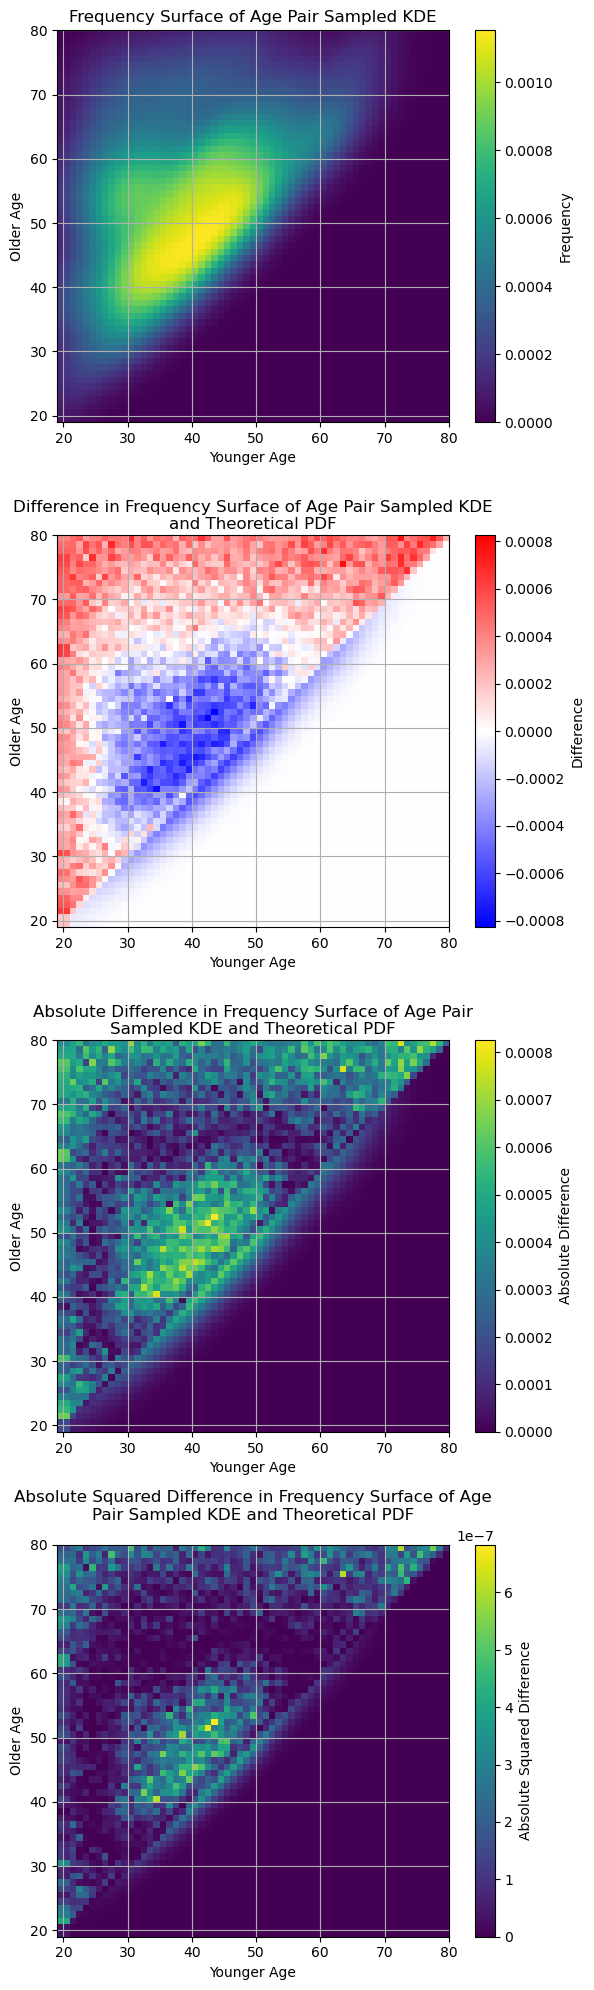

In [36]:
#10th batch
for i in range(8):
    run_batch()
    res = evaluate_dataset()
    scores["linear"].append(res['linear'])
    scores["squared"].append(res['squared'])
evaluate_dataset(plot=True)
scores

{'linear': 0.6205381198306865, 'squared': 0.00028650833907244275}

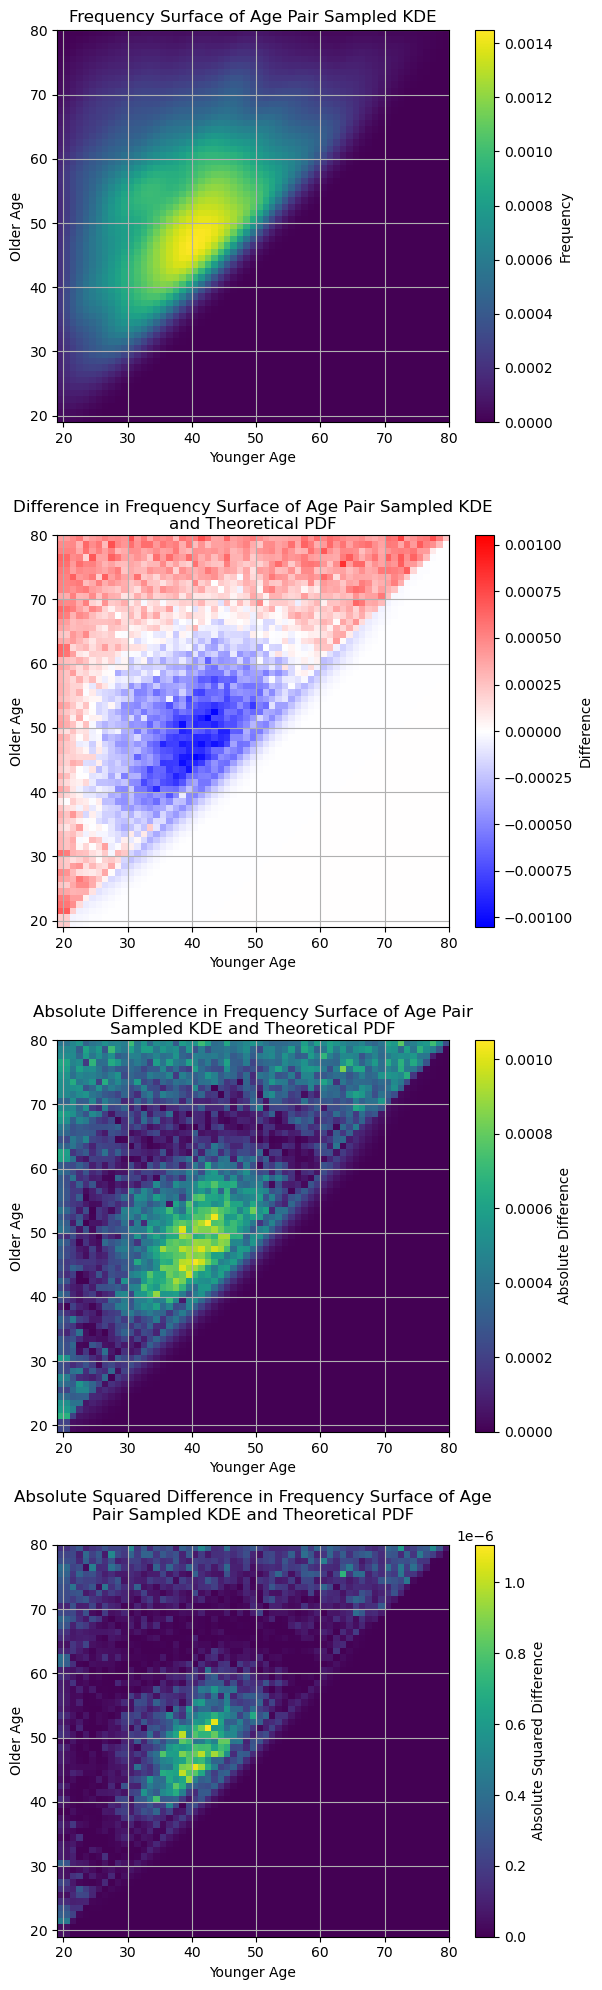

In [37]:
# 100th batches
for i in range(90):
    run_batch()
    res = evaluate_dataset()
    scores["linear"].append(res['linear'])
    scores["squared"].append(res['squared'])
evaluate_dataset(plot=True)

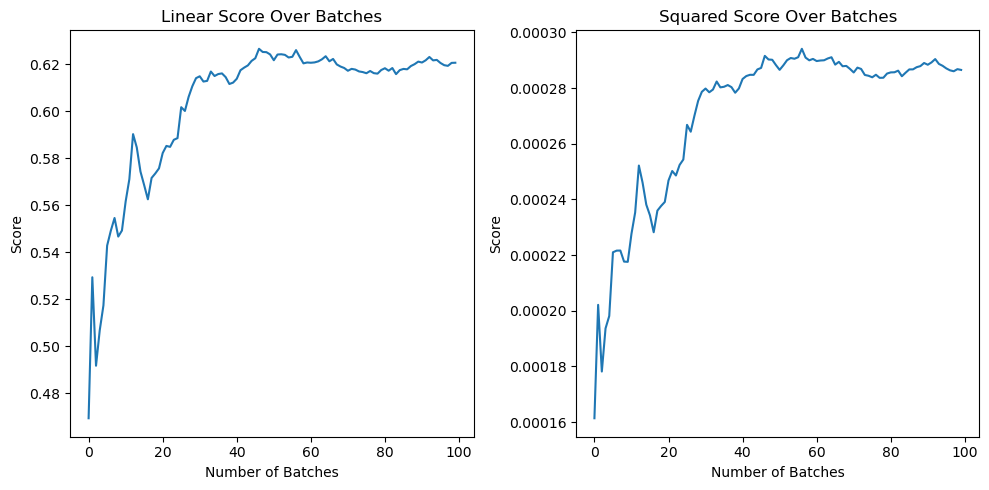

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(scores['linear'], label='linear')
ax[0].set_title("Linear Score Over Batches")
ax[0].set_xlabel('Number of Batches')
ax[0].set_ylabel('Score')

ax[1].plot(scores['squared'], label='squared')
ax[1].set_title("Squared Score Over Batches")
ax[1].set_xlabel('Number of Batches')
ax[1].set_ylabel('Score')
fig.tight_layout()

 # Baseline Check

In [44]:
b_stream = ParticipantStream(seed=3098)
b_pool = b_stream.generate_participants(10000)
b_samples = np.zeros((2, 5000))
for i in range(0, len(pool), 2):
    if b_pool[i]['age'] < b_pool[i+1]['age']:
        b_samples[0,i//2] = b_pool[i]['age']
        b_samples[1,i//2] = b_pool[i+1]['age']
    else:
        b_samples[0,i//2] = b_pool[i+1]['age']
        b_samples[1,i//2] = b_pool[i]['age']

In [45]:
b_kde = stats.gaussian_kde(b_samples)

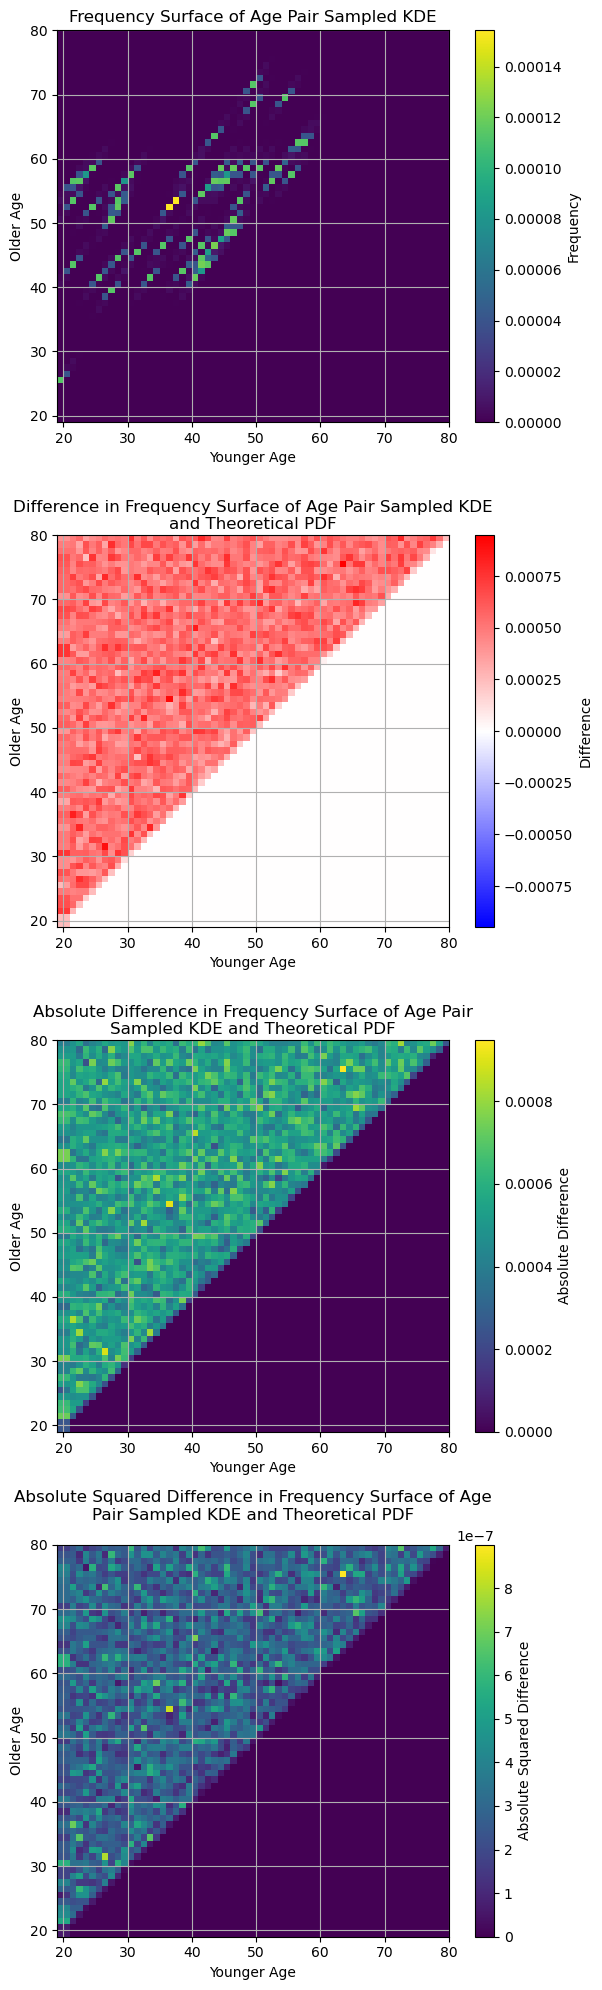

In [46]:
b_x_coords, b_y_coords = np.mgrid[19:80, 19:80]
b_pos = np.vstack([b_x_coords.ravel(), b_y_coords.ravel()])
b_z = np.reshape(b_kde(b_pos).T, b_x_coords.shape)
b_dif = np.reshape((age_pdf(b_pos[0], b_pos[1]) - b_kde(b_pos)).T, b_x_coords.shape)

fig, axes = plt.subplots(4, 1, figsize=(6, 20))

a0 = axes[0].imshow(b_z.T, origin='lower', extent=[19, 80, 19, 80])
fig.colorbar(a0, ax=axes[0], label='Frequency')
axes[0].set_title('Frequency Surface of Age Pair Sampled KDE')
axes[0].set_xlabel('Younger Age')
axes[0].set_ylabel('Older Age')
axes[0].grid(True)

cmap_max = np.max(np.abs(b_dif))
a1 = axes[1].imshow(b_dif.T, origin='lower', extent=[19, 80, 19, 80], cmap="bwr", vmin=-cmap_max, vmax=cmap_max)
fig.colorbar(a1, ax=axes[1], label='Difference')
axes[1].set_title('Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
axes[1].set_xlabel('Younger Age')
axes[1].set_ylabel('Older Age')
axes[1].grid(True)

a2 = axes[2].imshow(np.abs(b_dif).T, origin='lower', extent=[19, 80, 19, 80])
fig.colorbar(a2, ax=axes[2], label='Absolute Difference')
axes[2].set_title('Absolute Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
axes[2].set_xlabel('Younger Age')
axes[2].set_ylabel('Older Age')
axes[2].grid(True)

a3 = axes[3].imshow(np.abs(b_dif ** 2).T, origin='lower', extent=[19, 80, 19, 80])
fig.colorbar(a3, ax=axes[3], label='Absolute Squared Difference')
axes[3].set_title('Absolute Squared Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', pad=20, wrap=True)
axes[3].set_xlabel('Younger Age')
axes[3].set_ylabel('Older Age')
axes[3].grid(True)   

fig.tight_layout()

b_scores = {"linear": np.sum(np.triu(np.abs(b_dif))), "squared": np.sum(np.triu(np.abs(b_dif ** 2)))}

In [48]:
b_scores

{'linear': 0.9885089576864426, 'squared': 0.0005418416612532401}

In [54]:
datapoints.shape

(2, 5000)